In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, 'tools/')

from tools import * 

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 31.04 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39891,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 31.04 GiB
Comm: tcp://127.0.0.1:38845,Total threads: 4
Dashboard: http://127.0.0.1:38175/status,Memory: 6.21 GiB
Nanny: tcp://127.0.0.1:43831,


# Merge

In [3]:
config = pd.Series({
    'path': os.path.abspath('dades'),
    'file_type':'csv',
    'years':[2019, 2021, 2022, 2023],
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [4]:
%%time

def read_data_all(cnfg:dict):

    data = dict()

    for year in cnfg.years:
        cnfg['year'] = year
        data[year] = load_checkpoint(cnfg)
    
    return dd.concat(list(data.values()), interleave_partitions=False)
    
bbdd_completa = read_data_all(config)   

checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.
CPU times: user 49.5 ms, sys: 13.7 ms, total: 63.2 ms
Wall time: 60 ms


In [5]:
%%time

index=0
before = get_ddf_shape(bbdd_completa)
print(before)

index+=1
print(index)
# 1 Error fix. # 2019 gener, febrer and marc have the status reversed
cond = (bbdd_completa.year == 2019) & (bbdd_completa.month.isin([1,2,3]))
bbdd_completa['status'] = bbdd_completa['status'].mask(cond, ((bbdd_completa['status'] + 1) %2))
index+=1
print(index)
# 2 Remove not needed status, manitenance, planned. open = 0, closed = 1 
cond = (bbdd_completa['status'].isin([2.0,3.0]))
bbdd_completa['status'] = bbdd_completa['status'].mask(cond, 1.0)
# bbdd_completa = bbdd_completa.dropna(subset=['status'])
index+=1
print(index)
# 3 Remove data from 2020
cond = (bbdd_completa['year'].isin([2020]))
bbdd_completa = bbdd_completa.mask(cond, np.nan)
bbdd_completa = bbdd_completa.dropna(subset=['year'])
index+=1
print(index)
# 4 2019 to 2020 to have continuos data 
cond = (bbdd_completa['year'].isin([2019]))
bbdd_completa['year'] = bbdd_completa['year'].mask(cond, bbdd_completa['year']+1)
index+=1
print(index)
# 5 status reversed 
bbdd_completa['status'] = (bbdd_completa['status'] + 1)%2
index+=1
print(index)
# 6 Column has all ones
bbdd_completa = bbdd_completa.drop(columns=['is_installed'])
index+=1
print(index)
# 7 Column has all ones
bbdd_completa = bbdd_completa.drop(columns=['is_charging_station'])
index+=1
print(index)
# 8 Remove row where status = closed and is renting and is returning
# cond = (bbdd_completa['status'].isin([0.0])) & (bbdd_completa['is_renting'].isin([1.0])) & (bbdd_completa['is_returning'].isin([1.0]))
# bbdd_completa = bbdd_completa.mask(cond, np.nan)
# bbdd_completa = bbdd_completa.dropna(subset=['status'])

after = get_ddf_shape(bbdd_completa)
print(after)

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')

(14138683, 23)
1
2
3
4
5
6
7
8
(14138178, 21)
Changes to dataframe durinf preprocessing
dropeed -505 rows
dropped -2 columns
CPU times: user 3.58 s, sys: 235 ms, total: 3.81 s
Wall time: 15.9 s


In [6]:
%%time

unique_ids_by_year = bbdd_completa.groupby('year')['station_id'].unique().compute()
print(unique_ids_by_year)

# Calcula los station_id comunes en todos los años
common_ids = set(unique_ids_by_year[2020])
for year, ids in unique_ids_by_year.items():
    print(year, ids.shape)
    common_ids = common_ids.intersection(set(ids))
# common_ids
print(len(common_ids))

filtered_bbdd = bbdd_completa[bbdd_completa['station_id'].isin(common_ids)]
nonfiltered_bbdd = bbdd_completa[~bbdd_completa['station_id'].isin(common_ids)]

year
2020.0    [1, 320, 319, 318, 317, 316, 315, 314, 313, 31...
2021.0    [1.0, 271.0, 400.0, 510.0, 26.0, 270.0, 269.0,...
2022.0    [1, 380, 28, 379, 378, 377, 376, 375, 29, 374,...
2023.0    [1, 34, 386, 385, 384, 383, 35, 382, 381, 380,...
Name: station_id, dtype: object
2020.0 (410,)
2021.0 (509,)
2022.0 (510,)
2023.0 (508,)
405
CPU times: user 1.31 s, sys: 108 ms, total: 1.42 s
Wall time: 8.24 s


In [7]:
%%time

before = get_ddf_shape(filtered_bbdd)
print(before)

filtered_bbdd = filtered_bbdd.drop_duplicates(subset=['timestamp', 'station_id'], keep='last')

after = get_ddf_shape(filtered_bbdd)
print(after)

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')

(11935569, 21)


2023-06-06 01:27:52,837 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.01 GiB -- Worker memory limit: 6.21 GiB


(11815577, 21)
Changes to dataframe durinf preprocessing
dropeed -119992 rows
dropped 00 columns
CPU times: user 6.63 s, sys: 461 ms, total: 7.1 s
Wall time: 26.5 s


In [8]:
%%time

before = get_ddf_shape(nonfiltered_bbdd)
print(before)

nonfiltered_bbdd = nonfiltered_bbdd.drop_duplicates(subset=['timestamp', 'station_id'], keep='last')

after = get_ddf_shape(nonfiltered_bbdd)
print(after)

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')

(2202609, 21)
(2176820, 21)
Changes to dataframe durinf preprocessing
dropeed -25789 rows
dropped 00 columns
CPU times: user 6.29 s, sys: 437 ms, total: 6.72 s
Wall time: 23.1 s


# Predicción__________________________________
a) Regresión lineal: relación lineal entre las variables de entrada y la variable de salida. 

b) Regresión Redes Neuronales (RNN -redes neuronales recurrentes-): pueden capturar relaciones no lineales entre las variables de entrada y salida.

In [9]:
import os
import csv
import pandas as pd
import random
import numpy as np
import warnings
warnings.simplefilter('ignore')

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn import neighbors
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

DATA_DIR = 'dades'
OUTPUT_DIR = './'

In [11]:
class Config:
    num_attribs0 = ['year', 'ctx1', 'ctx2', 'ctx3', 'ctx4']
    cat_attribs0 = ['month', 'dayofweek', 'day', 'hour'] # dayofyear
    cat_attribs1 = ['station_id']
    gen_attribs0 = [] # ['status']
    target_col = ['ctx0']

    epochs=5
    batch_size=128
    seed=42
    embedding_dim=8
    lr=1e-4

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    

In [12]:
config=Config()
seed_everything(config.seed)

In [13]:
filtered_bbdd.columns

Index(['station_id', 'num_docks_available', 'num_bikes_available', 'status',
       'timestamp', 'is_renting', 'is_returning',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'year', 'month', 'dayofweek', 'day',
       'dayofyear', 'hour', 'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3',
       'ctx4'],
      dtype='object')

In [14]:

def build_preprocessor(config): 
    num_attribs0 = config.num_attribs0 # ['year', 'ctx1', 'ctx2', 'ctx3', 'ctx4']
    cat_attribs0 = config.cat_attribs0 #['month', 'dayofweek', 'day', 'dayofyear', 'hour' ]
    cat_attribs1 = config.cat_attribs1 #['station_id']
#     gen_attribs0 = config.gen_attribs0 #['status']
    
    num_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ('std_scaler', (StandardScaler())),
    ])

    categorical_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('ordinal_encoder', (OrdinalEncoder())),
    ])
    
    categorical_transformer1 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('one_hot_encoder', (OneHotEncoder(handle_unknown='ignore'))),
    ])
    
#     generic_transformer0 = Pipeline([
#         ("imputer", SimpleImputer(strategy="mean")),
#     ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num0", num_transformer0, num_attribs0),
#             ("gen1", generic_transformer0, gen_attribs0),
            ("cat0", categorical_transformer0, cat_attribs0),
            ("cat1", categorical_transformer1, cat_attribs1),
        ],
        remainder="drop"
    )
    
    return preprocessor

def apply_pipeline(config, x_train,x_test,y_train,y_test, show=True):
    
    full_pipeline = build_preprocessor(config)

    x_train_prepared = full_pipeline.fit_transform(x_train)
    x_test_prepared = full_pipeline.transform(x_test)
    
    if show:
        print("x_train_prepared:",x_train_prepared.shape,"y_train: ",y_train.shape)
        print("x_test_prepared:",x_test_prepared.shape,"y_test: ",y_test.shape)

    return x_train_prepared,x_test_prepared,y_train,y_test


In [15]:
train_data2022 = filtered_bbdd[filtered_bbdd.year.isin([2022])]
get_ddf_shape(train_data2022)

2023-06-06 01:28:30,497 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:38845 (pid=8614) exceeded 95% memory budget. Restarting...
2023-06-06 01:28:30,756 - distributed.nanny - WARNING - Restarting worker
2023-06-06 01:28:45,252 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 5.06 GiB -- Worker memory limit: 6.21 GiB
2023-06-06 01:28:45,437 - distributed.worker.memory - WARNING - Worker is at 64% memory usage. Resuming worker. Process memory: 4.00 GiB -- Worker memory limit: 6.21 GiB
2023-06-06 01:28:45,795 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.00 GiB -- Worker memory limit: 6.21 GiB


(3528441, 21)

In [16]:
val_data2022= nonfiltered_bbdd[nonfiltered_bbdd.year.isin([2022])]
get_ddf_shape(val_data2022)

(896320, 21)

In [17]:
val_data2023 = bbdd_completa[bbdd_completa.year.isin([2023])]
get_ddf_shape(val_data2023)

(1717677, 21)

In [25]:
%%time 

X_train, y_train = train_data2022.compute().copy(), train_data2022.ctx0.compute().copy()

2023-06-06 01:30:04,355 - distributed.worker.memory - WARNING - Worker is at 89% memory usage. Pausing worker.  Process memory: 5.56 GiB -- Worker memory limit: 6.21 GiB
2023-06-06 01:30:04,463 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:44169 (pid=8622) exceeded 95% memory budget. Restarting...
2023-06-06 01:30:04,692 - distributed.nanny - WARNING - Restarting worker
2023-06-06 01:30:17,941 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.03 GiB -- Worker memory limit: 6.21 GiB
2023-06-06 01:30:33,862 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-

CPU times: user 6.29 s, sys: 1.49 s, total: 7.78 s
Wall time: 43.5 s


In [19]:
%%time 

X_val1, y_val1 = val_data2022.compute().copy(), val_data2022.ctx0.compute().copy()

CPU times: user 3.12 s, sys: 401 ms, total: 3.52 s
Wall time: 20 s


In [20]:
%%time 

X_val2, y_val2 = val_data2023.compute().copy(), val_data2023.ctx0.compute().copy()

CPU times: user 2.95 s, sys: 645 ms, total: 3.6 s
Wall time: 17.4 s


In [26]:
%%time 

full_pipeline = build_preprocessor(config)

X_train_prepared = full_pipeline.fit_transform(X_train)
X_val_prepared1 = full_pipeline.transform(X_val1)
X_val_prepared2 = full_pipeline.transform(X_val2)

print("x_train_prepared:",X_train_prepared.shape,"y_train: ",y_train.shape)
print("x_test_prepared:",X_val_prepared1.shape,"y_test: ",y_val1.shape)
print("x_test_prepared:",X_val_prepared2.shape,"y_test: ",y_val2.shape)


x_train_prepared: (3528441, 414) y_train:  (3528441,)
x_test_prepared: (896320, 414) y_test:  (896320,)
x_test_prepared: (1717677, 414) y_test:  (1717677,)
CPU times: user 3.78 s, sys: 591 ms, total: 4.37 s
Wall time: 3.95 s


In [27]:
%%time 

lin_reg = LinearRegression()
cross_val_evaluation(lin_reg,X_train_prepared, y_train,'Linear Regression')
#  Linear Regression
# Scores: [0.86876116 0.85690033 0.83716171 0.82008556 0.8135665 ]
# Mean: 0.8392950517172396
# Standard deviation: 0.021041440859117303


  Linear Regression
Scores: [0.81376396 0.81734464 0.81327889 0.81496388 0.81662265]
Mean: 0.8151948035212062
Standard deviation: 0.0015768274641091901
CPU times: user 41.1 s, sys: 2min 6s, total: 2min 47s
Wall time: 12.5 s


In [28]:
%%time 

lin_reg.fit(X_train_prepared,y_train)

CPU times: user 8.51 s, sys: 26.9 s, total: 35.4 s
Wall time: 2.71 s


LinearRegression()


Training time: 0.06 s
----- EVALUATION ON VAL SET ------
MSE: 0.012614436378654765
RMSE 0.11231400793603069
MAE: 0.07490800229416943
R^2:  0.8152555228518599



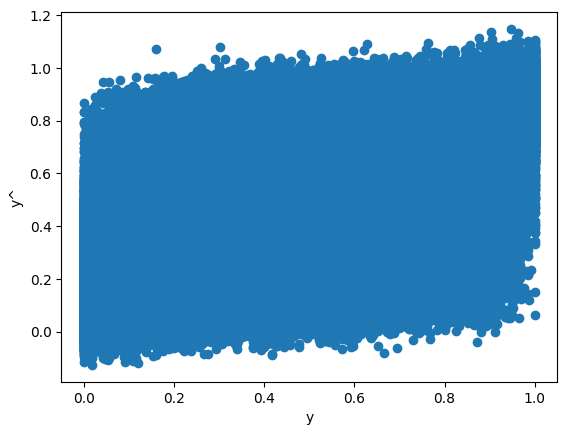

y_hat_t    [0.5938802737395218, 0.5960703506612646, 0.596...
mse_t                                               0.012614
rmse_t                                              0.112314
mae_t                                               0.074908
r2_t                                                0.815256
dtype: object

In [29]:
test_model(lin_reg, X_train_prepared, y_train)


Training time: 0.011 s
----- EVALUATION ON VAL SET ------
MSE: 0.009295025204184636
RMSE 0.09641071104490744
MAE: 0.06525489836910126
R^2:  0.8568434837101825



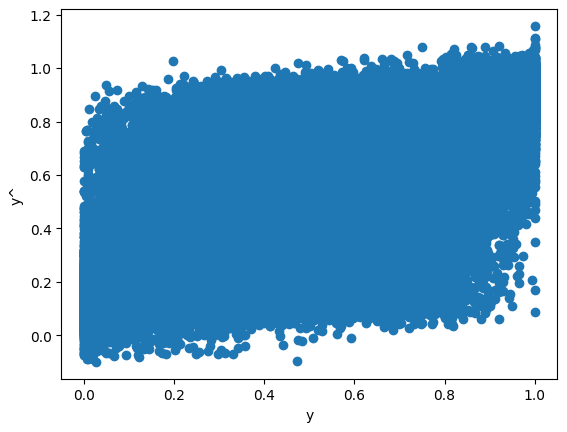


Testing time: 0.025 s
----- EVALUATION ON VAL SET ------
MSE: 0.01300678644104816
RMSE 0.11404729913964715
MAE: 0.07710885103814304
R^2:  0.8192889366434029



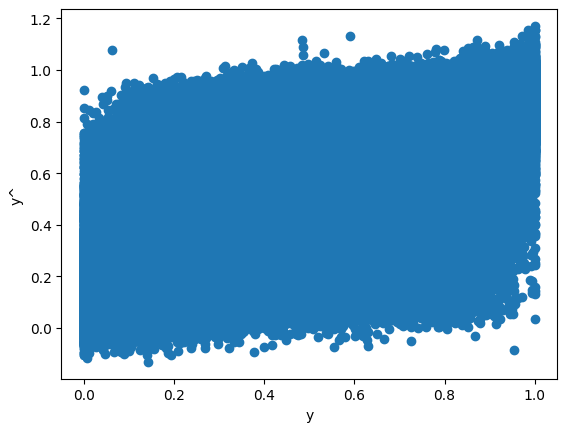

y_hat_t    [0.811169587637445, 0.7306573569954977, 0.8430...
mse_t                                               0.009295
rmse_t                                              0.096411
mae_t                                               0.065255
r2_t                                                0.856843
y_hat_v    [0.2056410297551841, 0.209345569557145, 0.2883...
mse_v                                               0.013007
rmse_v                                              0.114047
mae_v                                               0.077109
r2_v                                                0.819289
dtype: object

In [30]:
test_model(lin_reg, X_val_prepared1, y_val1, X_val_prepared2, y_val2)

## KNN3

## SVM 

## Random forest

## Gradiend Boosting

## NN 

## Generate Sample

In [ ]:
sample_data = pd.read_csv('dades/metadata_sample_submission.csv/metadata_sample_submission.csv')

In [ ]:
sample_data['year'] = 2023

In [ ]:
sample_data['datetime'] = pd.to_datetime(sample_data[['year','month','day']])
sample_data['dayofweek'] = sample_data.datetime.dt.dayofweek


In [ ]:
sample_data.drop(['datetime', 'index'], axis=1, inplace=True)

In [ ]:
sample_data.rename(
    columns = {
        'ctx-4':'ctx4',
        'ctx-3':'ctx3',
        'ctx-2':'ctx2',
        'ctx-1':'ctx1'
    },
    inplace=True
)

In [ ]:
sample_data

In [ ]:
# (config, x_train,x_val,y_train,y_val)
show = True
full_pipeline = build_preprocessor(config)

X_train_prepared = full_pipeline.fit_transform(X_train)
X_val_prepared1 = full_pipeline.transform(X_val1)
X_val_prepared2 = full_pipeline.transform(X_val2)
X_test_prepared = full_pipeline.transform(sample_data)

if show:
    print("x_train_prepared:",x_train_prepared.shape,"y_train: ",y_train.shape)
    print("x_test_prepared:",x_val_prepared.shape,"y_test: ",y_val.shape)
    print("x_test_prepared:",x_test_prepared.shape)


In [ ]:
%%time 

lin_reg = LinearRegression()
cross_val_evaluation(lin_reg,x_train_prepared, y_train,'Linear Regression')


In [ ]:
lin_reg.fit(x_train_prepared,y_train)
test_model(lin_reg, x_train_prepared, y_train, x_val_prepared, y_val)

In [ ]:
yhat = lin_reg.predict(x_test_prepared)


In [ ]:
yhat.shape

In [ ]:
sample_data['percentage_docks_available'] = yhat

In [ ]:
sample_data['percentage_docks_available'].to_csv('predicton_lr.csv', header=True)